# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [ ]:
#Все библиотеки в отдельную ячейку
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
import numpy as np

In [ ]:
#загрузим данные из имеющихся датасетов
data_reg1 = pd.read_csv("/datasets/geo_data_0.csv")
data_reg2 = pd.read_csv("/datasets/geo_data_1.csv")
data_reg3 = pd.read_csv("/datasets/geo_data_2.csv")

In [ ]:
data_regs = [data_reg1, data_reg2, data_reg3]

**Используя методы head, info, shape - посмотрим какие данные представлены в датафреймах.**

In [ ]:
i = 1
for reg in data_regs:
    print(f"Регион №{i}:\n {reg.head()} \nРазмер: {reg.shape}\n")
    i += 1


Регион №1:
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 
Размер: (100000, 5)

Регион №2:
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 
Размер: (100000, 5)

Регион №3:
       id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  1

In [ ]:
#Изучим общую информацию о данных
for reg in data_regs:
    print(reg.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

**Три датафрейма с информацией  о пробах нефти в трёх регионах. Размер каждого датафрейма 100000 строк, 4 столбца.**
- id - уникальный номер скважины
- f0, f1, f2 — три признаки точек - признаки для предсказаний;
- product — объём запасов в скважине (тыс. баррелей) - **это будет целевой признак.**

**Проверим данные на наличие пропусков и дубликатов.**

In [ ]:
for reg in data_regs:
    print(reg.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [ ]:
#нашли дубликаты
for reg in data_regs:
    print(reg['id'].duplicated().sum())

10
4
4


**Устраним выявленные дубликаты.**

In [ ]:
def regs_drop_duplicates(name_regs):
    name_regs=name_regs.drop_duplicates(subset=['id']).reset_index(drop=True)
    return name_regs

In [ ]:
data_reg1 = regs_drop_duplicates(data_reg1)
data_reg2 = regs_drop_duplicates(data_reg2)
data_reg3 = regs_drop_duplicates(data_reg3)

In [ ]:
data_reg3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Выявлены дубликаты в id. Дубликаты устранены.**

**Пропусков нет, данные в ячейка f0, f1, f2 вещественного типа - количественные. В id - уникальный номер скважины, не значимый признак. Поэтому "id" удалим.**

In [ ]:
data_reg1 = data_reg1.drop(['id'], axis=1)

In [ ]:
data_reg2 = data_reg2.drop(['id'], axis=1)

In [ ]:
data_reg3 = data_reg3.drop(['id'], axis=1)

In [ ]:
print(data_reg1.shape, data_reg2.shape,data_reg3.shape)

(99990, 4) (99996, 4) (99996, 4)


**Проверим, как данные коррелируют друг с другом**

In [ ]:
i = 1
for reg in data_regs:
    print("Корреляция по региону №", i)
    print(reg.corr(),"\n")
    i+=1

Корреляция по региону № 1
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000 

Корреляция по региону № 2
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000 

Корреляция по региону № 3
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000 



**Корреляция в данных**
- Наблюдается сильная корреляция по второму региону между целевым признаком и признаком f2.
- По первому и третьему регионам между целевым признаком и признаком f2 также есть положительная корреляция, она меньше.
- Два других признака f0,f1  практически не коррелируют с целевым в регионах 2 и 3, и слабо отрицательно в регионе 2.**


**Итак, признак f2 - оказывает сильное влияние на целевой признак.**

Построим гистограммы распределения объема запасов в скважинах по регионам

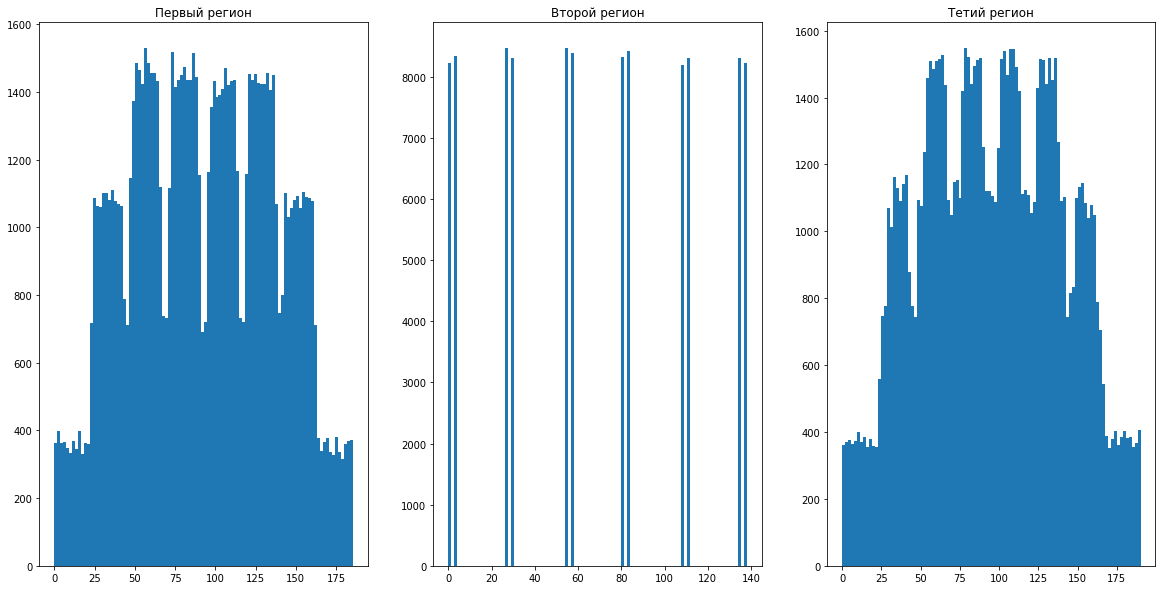

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].set_title("Первый регион")
axes[0].hist(data_reg1['product'], bins = 100);

axes[1].set_title("Второй регион")
axes[1].hist(data_reg2['product'], bins = 100);


axes[2].set_title("Тетий регион")
axes[2].hist(data_reg3['product'], bins = 100);

Первый и третий регионы - распределение приближается к нормальному, второй регион - наблюдается неравномерное распределение.

Ниже - диаграммы рассеяния, демонстрирующие корреляцию между объемом запаса в скважинах и признаком f2.Во втором регионе - зависимость идеальная. В первом и третьем - больше похожа на  естественную.

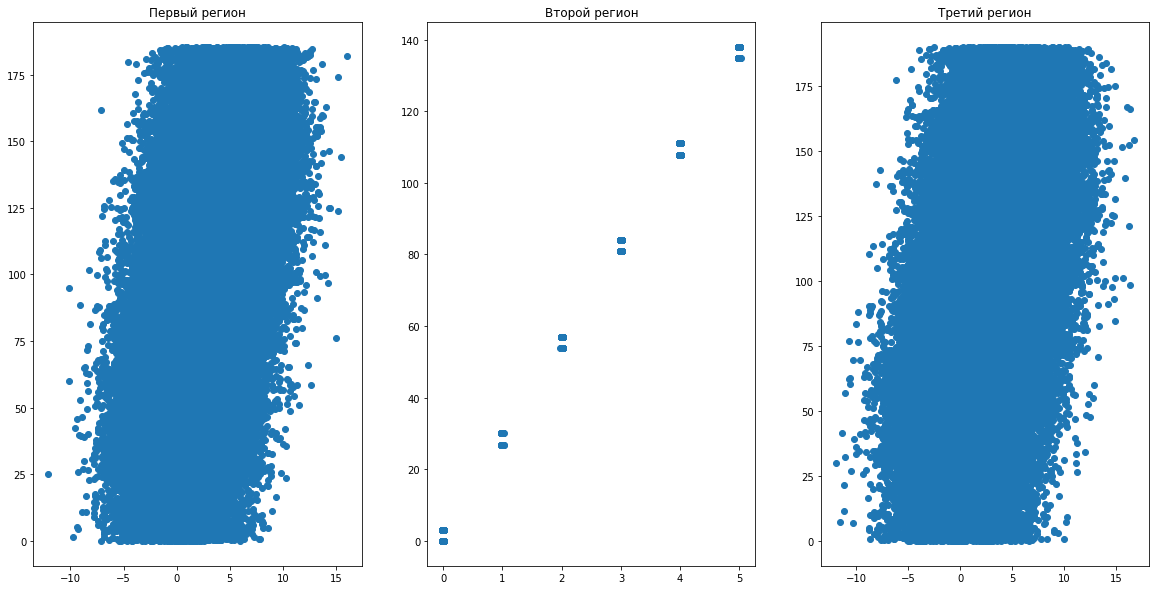

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].set_title("Первый регион")
axes[0].scatter(data_reg1['f2'], data_reg1['product']);

axes[1].set_title("Второй регион")
axes[1].scatter(data_reg2['f2'], data_reg2['product']);


axes[2].set_title("Третий регион")
axes[2].scatter(data_reg3['f2'], data_reg3['product']);


Визуально второй регион отличается снова отличается.

## Обучение и проверка модели

Создадим отдельную функцию для разбиения данных на выборки. И выполним это разбиение.

In [ ]:
def split_regions(data_name):
    target_reg = data_name['product']
    features_reg = data_name.drop('product', axis=1)

    lst_split = train_test_split(features_reg, target_reg, random_state=12345, test_size=0.25)

    return lst_split

In [ ]:
features_train_reg1, features_valid_reg1, target_train_reg1, target_valid_reg1 = split_regions(data_reg1)

In [ ]:
features_train_reg1.head()

,f0,f1,f2
75161,1.175747,-0.382577,2.280279
43240,-0.878080,0.162056,-1.655183
91987,-0.064050,0.320469,0.861030
5094,0.055304,0.884562,-0.276966
78245,-0.143708,1.026059,1.291161


In [ ]:
features_train_reg2, features_valid_reg2, target_train_reg2, target_valid_reg2 = split_regions(data_reg2)

In [ ]:
features_train_reg2.head()

,f0,f1,f2
7866,18.819463,4.602079,2.996867
83619,-6.162089,4.048343,3.007117
45141,-9.062697,-1.046600,5.005842
35823,7.039176,5.176089,-0.000562
17773,17.019966,-6.441701,3.998933


In [ ]:
features_train_reg3, features_valid_reg3, target_train_reg3, target_valid_reg3 = split_regions(data_reg3)

In [ ]:
def print_korr_split(features_train, target_train, features_valid, target_valid):
    print("Обучающая выборка", features_train.shape,target_train.shape)
    print("Валидационная выборка", features_valid.shape, target_valid.shape)

In [ ]:
#Выполним контроль корректности разбиения
print_korr_split(features_train_reg1, target_train_reg1, features_valid_reg1, target_valid_reg1)
print()
print_korr_split(features_train_reg2, target_train_reg2, features_valid_reg2, target_valid_reg2)
print()
print_korr_split(features_train_reg3, target_train_reg3, features_valid_reg3, target_valid_reg3)

Обучающая выборка (74992, 3) (74992,)
Валидационная выборка (24998, 3) (24998,)

Обучающая выборка (74997, 3) (74997,)
Валидационная выборка (24999, 3) (24999,)

Обучающая выборка (74997, 3) (74997,)
Валидационная выборка (24999, 3) (24999,)


In [ ]:
data_reg1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


**Масштабирование выполнять не надо. Данные вполне сопоставимы.**

Обучим модель линейной регрессии на тренировочной выборке. И выполним предсказания на валидационной выборке. Посчитаем значения метрик, в каждом регионе. Для этого напишем сответствующую функцию.

In [ ]:
def metrics_model(feature_train, target_train, feature_valid, target_valid):
    model = LinearRegression()
    model.fit(feature_train, target_train)

    predictions_valid = model.predict(feature_valid)

    #Предсказанные данные для региона в Series
    predictions_valid_df = pd.Series(predictions_valid)

    result = mean_squared_error(target_valid, predictions_valid)

    print("R2 =", r2_score(target_valid, predictions_valid))
    print("RMSE на валидационной выборке:", result**0.5)
    print("MSE на валидационной выборке:", result)
    print("MAE  на валидационной выборке:", mean_absolute_error(target_valid, predictions_valid))

    return predictions_valid_df


In [ ]:
#Для первого региона
predictions_valid_reg1 = metrics_model(features_train_reg1, target_train_reg1, features_valid_reg1, target_valid_reg1)

print("Средний предсказанный запас на 1 скважину по первому региону:",predictions_valid_reg1.mean())

R2 = 0.2723923460817068
RMSE на валидационной выборке: 37.853527328872964
MSE на валидационной выборке: 1432.8895312377324
MAE  на валидационной выборке: 31.141028675220266
Средний предсказанный запас на 1 скважину по первому региону: 92.78915638280621


In [ ]:
#Для второго региона
predictions_valid_reg2 = metrics_model(features_train_reg2, target_train_reg2, features_valid_reg2, target_valid_reg2)

print("Средний предсказанный запас на 1 скважину по второму региону:",predictions_valid_reg2.mean())

R2 = 0.9996222988190184
RMSE на валидационной выборке: 0.892059264771703
MSE на валидационной выборке: 0.7957697318650314
MAE  на валидационной выборке: 0.7193530096516099
Средний предсказанный запас на 1 скважину по второму региону: 69.17831957030432


In [ ]:
#Для третьего региона
predictions_valid_reg3 = metrics_model(features_train_reg3, target_train_reg3, features_valid_reg3, target_valid_reg3)

print("Средний предсказанный запас на 1 скважину по третьему региону:",predictions_valid_reg3.mean())

R2 = 0.19556241810202346
RMSE на валидационной выборке: 40.07585073246016
MSE на валидационной выборке: 1606.0738119304278
MAE  на валидационной выборке: 32.83139014902301
Средний предсказанный запас на 1 скважину по третьему региону: 94.86572480562035


**Для второго региона значение метрики лучше всего.**

**Предсказания для регионов**

In [ ]:
predict_regs = [predictions_valid_reg1, predictions_valid_reg2, predictions_valid_reg3]
i = 1
for reg in predict_regs:
    print("Предсказания для региона №",i,"\n\n",reg,"\n")
    i+=1

Предсказания для региона № 1 

 0        103.950372
1         73.687869
2        101.015288
3         94.048415
4         87.559552
            ...    
24993     63.963223
24994    139.862730
24995     78.444653
24996     71.082768
24997     66.054854
Length: 24998, dtype: float64 

Предсказания для региона № 2 

 0         53.407255
1        137.863458
2         29.745003
3         83.188229
4          1.242101
            ...    
24994    110.688350
24995     81.716127
24996     54.611428
24997    107.578737
24998      1.969338
Length: 24999, dtype: float64 

Предсказания для региона № 3 

 0         76.457565
1        109.417094
2         89.922620
3         83.701818
4         86.761173
            ...    
24994     95.591732
24995    112.126588
24996     62.367249
24997    114.190814
24998     86.998804
Length: 24999, dtype: float64 



Посчитаем количество ответов в выборках по регионам, чтобы убедиться, что дисбаланса нет. Хотя уже и так понятно, что его нет.

In [ ]:
def answer_models(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)

    LnR_series = pd.Series(model.predict(features_valid)).value_counts(normalize = 1)

    print(f"Количество ответов:\n{LnR_series}" , end='\n')
    print()


In [ ]:
answer_models(features_train_reg1, target_train_reg1, features_valid_reg1, target_valid_reg1)

Количество ответов:
65.124711     0.00004
105.632899    0.00004
76.256135     0.00004
99.988687     0.00004
107.980005    0.00004
               ...   
63.088476     0.00004
97.589573     0.00004
72.145669     0.00004
72.045439     0.00004
89.282138     0.00004
Length: 24998, dtype: float64



In [ ]:
answer_models(features_train_reg2, target_train_reg2, features_valid_reg2, target_valid_reg2)

Количество ответов:
56.236503     0.00004
112.080498    0.00004
109.686071    0.00004
80.046232     0.00004
80.913687     0.00004
               ...   
79.966338     0.00004
83.995824     0.00004
56.838305     0.00004
83.730566     0.00004
84.316554     0.00004
Length: 24999, dtype: float64



In [ ]:
answer_models(features_train_reg3, target_train_reg3, features_valid_reg3, target_valid_reg3)

Количество ответов:
78.656628     0.00004
96.176836     0.00004
74.041804     0.00004
134.235033    0.00004
55.237878     0.00004
               ...   
110.461921    0.00004
89.421475     0.00004
73.738149     0.00004
61.159288     0.00004
61.110891     0.00004
Length: 24999, dtype: float64



**Дисбаланс не наблюдается.**

Сравним предсказанные данные с реальными

In [ ]:
def predict_real_data(target_data, predict_data):
    data_predict_real = pd.concat([target_data.reset_index(drop=True), pd.DataFrame(predict_data)], axis = 1)
    data_predict_real.columns = ['real', 'predict']
    print(data_predict_real.head(10))

In [ ]:
print("Регион №1")
predict_real_data(target_valid_reg1, predictions_valid_reg1)

Регион №1
         real     predict
0  123.566299  103.950372
1   63.442039   73.687869
2   88.718000  101.015288
3   51.422060   94.048415
4  102.569999   87.559552
5   36.308374   64.885772
6   69.669767  121.873997
7  136.730952   82.137868
8   29.091859   85.330138
9  126.004696   96.607296


In [ ]:
print("Регион №2")
predict_real_data(target_valid_reg2, predictions_valid_reg2)

Регион №2
         real     predict
0   53.906522   53.407255
1  137.945408  137.863458
2   30.132364   29.745003
3   84.038886   83.188229
4    0.000000    1.242101
5  110.992147  111.433035
6  137.945408  137.129669
7  134.766305  135.126301
8   84.038886   83.083272
9    3.179103    2.505282


In [ ]:
print("Регион №3")
predict_real_data(target_valid_reg3, predictions_valid_reg3)

Регион №3
         real     predict
0   97.651721   76.457565
1   66.640660  109.417094
2   57.776581   89.922620
3   35.055066   83.701818
4   82.047594   86.761173
5  105.904629  122.198051
6   51.646180  119.305740
7  155.098655  108.019369
8  139.820559   97.141514
9   16.230778   97.781075


**Снова регион №2 показывает лучшие результаты. Получается, что регион №2 - самый "подозрительный" на "лучшесть". Он выбивается по показателям от двух других - по метрикам, по корреляции, визуально. И модель предскавает данные во втором регионе точнее.**


Тем не менее, без расчета перспективной прибыли никуда.

## Подготовка к расчёту прибыли

**Условия задачи:**

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.**


**Для всех ключевых значений создадим константы**

In [ ]:
budzhet = 10**10 # Общий бюджет на разработку
one_unit_price = 450_000 # Доход с каждой 1000 баррелей составляет 450 тыс. рублей
points500 = 500 # Количество исследуемых точек
points200 = 200 # Количество лучших точек для разработки
barrel = 450 # стоимость 1 барреля

**Посчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки**

In [ ]:
average_cost_one = budzhet / points200
print("Средняя безубыточная окупаемость разработки новой скважины (при 200) - ", average_cost_one)

average_volume_one = average_cost_one / one_unit_price
print("Средний безубыточный объем с одной скважины - ", average_volume_one)

average_volume_region = budzhet / one_unit_price
print("Средний безубыточный объем на регион - ", average_volume_region)


Средняя безубыточная окупаемость разработки новой скважины (при 200) -  50000000.0
Средний безубыточный объем с одной скважины -  111.11111111111111
Средний безубыточный объем на регион -  22222.222222222223


In [ ]:
print("Средний предсказанный запас на 1 скважину по первому региону:",predictions_valid_reg1.mean())
print("Средний предсказанный запас на 1 скважину по второму региону:",predictions_valid_reg2.mean())
print("Средний предсказанный запас на 1 скважину по третьему региону:",predictions_valid_reg3.mean())

Средний предсказанный запас на 1 скважину по первому региону: 92.78915638280621
Средний предсказанный запас на 1 скважину по второму региону: 69.17831957030432
Средний предсказанный запас на 1 скважину по третьему региону: 94.86572480562035


In [ ]:
def sub_aver(reg, i):
    print(f"Регион №{i} |{round(reg,3)} | {round((reg - average_volume_one),3)}|")

In [ ]:
print("Сравнение полученных и реальных средних по регионам")
print("\t  прогноз  разница")
print("____________________________")
sub_aver(predictions_valid_reg1.mean(),1)
sub_aver(predictions_valid_reg2.mean(),2)
sub_aver(predictions_valid_reg3.mean(),3)
print("____________________________")


Сравнение полученных и реальных средних по регионам
	  прогноз  разница
____________________________
Регион №1 |92.789 | -18.322|
Регион №2 |69.178 | -41.933|
Регион №3 |94.866 | -16.245|
____________________________


**Получается, что предсказанные запасы во всех трех регионах не позволяют полностью сразу окупить бюджет. Так ситуация выглядит по средним. Средний запас на 1 скважину во всех трех регионах меньше рассчитанного безубыточного объема. Причем, в первом и третьем эта разница значительно меньше, чем во втором.**



## Расчёт прибыли и рисков

In [ ]:
def series_type(target, pred):
    target = target.reset_index(drop=True)
    pred = pd.Series(pred)
    return target, pred

In [ ]:
target_valid_reg1 ,predictions_valid_reg1 = series_type(target_valid_reg1 ,predictions_valid_reg1)
target_valid_reg2 ,predictions_valid_reg2 = series_type(target_valid_reg2 ,predictions_valid_reg2)
target_valid_reg3 ,predictions_valid_reg3 = series_type(target_valid_reg3,predictions_valid_reg3)

Функция revenue() подсчитывает и возвращает выручку.

In [ ]:
def revenue(target, probabilities, count):
    probs_sorted = pd.Series(probabilities).sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return round(one_unit_price * selected.sum() - budzhet,3)

In [ ]:
print("Регион №1", revenue(target_valid_reg1 ,predictions_valid_reg1,500))
print("Регион №2",revenue(target_valid_reg2 ,predictions_valid_reg2,500))
print("Регион №3",revenue(target_valid_reg3 ,predictions_valid_reg3,500))

Регион №1 22498449585.5
Регион №2 21037716741.704
Регион №3 20550987726.9


Проведем поцедуру Bootstrap и посчитаем прибыль и риски.

In [ ]:
def bootstrap_regions(target, predicted):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n = 500, replace=True, random_state=state)

        pred_subsumple = predicted[target_subsample.index]

        values.append(revenue(target_subsample, pred_subsumple, 200))

    values = pd.Series(values)
    values_mean = values.mean()
    lower = values.quantile(q=0.025)
    upper = values.quantile(q=0.975)
    risk = len(values[values < 0]) / len(values) * 100
    out = f"прогноз.средн.прибыль: {round(values_mean,3)}, доверительный интервал:({round(lower,3)}, {round(upper,3)})"
    return f"{out}, риск убытков: {round(risk,3)} %"

In [ ]:
print("Регион №1:", bootstrap_regions(target_valid_reg1, predictions_valid_reg1))
print("Регион №2:", bootstrap_regions(target_valid_reg2, predictions_valid_reg2))
print("Регион №3:", bootstrap_regions(target_valid_reg3, predictions_valid_reg3))

Регион №1: прогноз.средн.прибыль: 409428038.621, доверительный интервал:(-131536028.702, 944395582.755), риск убытков: 7.1 %
Регион №2: прогноз.средн.прибыль: 536902587.487, доверительный интервал:(114527902.902, 970787910.995), риск убытков: 0.9 %
Регион №3: прогноз.средн.прибыль: 353790362.731, доверительный интервал:(-159194031.191, 875652502.871), риск убытков: 10.2 %


**Вывод**

В ходе исследования выполнена предобработка данных:
- устранены дубликаты;
- проверены на наличие пропусков
- проверены типы данных

Выявлено:
- корреляция между признаками и целевым признаком. Оказалось, что признак  f2 сильно влияет на целевой признак,  влияние двух других незначительное.
- выявлено особенно сильная зависимость во втором регионе.
- второй регион сразу же явно выделяется из всех трех.

Данные по всем трем регионам разбиты на две выборки – обучающую и валидационную.
Построены модели линейной регрессии по всем трем регионам, модели обучены. На валидационных данных сделаны предсказания.
Данные предсказаний сравниваются с целевыми значениями на валидации. И снова самые близкие значения по второму региону.

Посчитаны метрики MSE, RMSE, MAE, R2 по всем трем регионам.  Значения метрик по второму региону самые лучшие в сравнении с двумя другими:
- R2 = 0.9996222988190184
- RMSE на валидационной выборке: 0.892059264771703
- MSE на валидационной выборке: 0.7957697318650314
- MAE  на валидационной выборке: 0.7193530096516099

По всем трем регионам посчитаны средние показатели запаса на скважину. При расчете безубыточной прибыли оказалось, что средние значения запасов на 1 скважину во всех трех регионах не достаточны.
Средний безубыточный объем с одной скважины -  111.11111111111111

Тогда как

- Средний предсказанный запас на 1 скважину по первому региону: 92.78915638280621
- Средний предсказанный запас на 1 скважину по второму региону: 69.17831957030432
- Средний предсказанный запас на 1 скважину по третьему региону: 94.86572480562035

Тем не менее, при отборе лучших скважин, возможно эти значения поменяются. Для этого проводилась техника бутстреп, которая показала следующие значения:
- Регион №1: прогноз.средн.прибыль: 409428038.621, доверительный интервал:(-131536028.702, 944395582.755), риск убытков: 7.1 %
- Регион №2: прогноз.средн.прибыль: 536902587.487, доверительный интервал:(114527902.902, 970787910.995), риск убытков: 0.9 %
- Регион №3: прогноз.средн.прибыль: 353790362.731, доверительный интервал:(-159194031.191, 875652502.871), риск убытков: 10.2 %

Таким образом,

**исследование показало, что наиболее перспективным для разработок является Регион №2.**
- В нем наблюдается высокая корреляция между признаков f2 и целевым признаком.<br/>
- Предсказания по второму региону получились самыми точными.<br/>
- Бутстреп показал самую высокую среднюю прибыль и самые низкие риски убытков.









